In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [1]:
import tensorflow
print(" Prioritizing memory GPU for processing ".upper().center(75, "*"))
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
  print("GPU is available")
  try:
    for gpu in gpus:
      tensorflow.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tensorflow.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print("*"*75)
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
print("*"*75)
with tensorflow.device('/GPU:0'):
  a = tensorflow.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tensorflow.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tensorflow.matmul(a, b)
print(c)
print("*"*75)
print(tensorflow.config.list_physical_devices('GPU'))
print("*"*75)
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
  try:
    tensorflow.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tensorflow.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)

****************** PRIORITIZING MEMORY GPU FOR PROCESSING *****************
GPU is available
1 Physical GPUs, 1 Logical GPUs
***************************************************************************
Num GPUs Available:  1
***************************************************************************
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
***************************************************************************
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
***************************************************************************
1 Physical GPUs, 1 Logical GPU


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import pandas as pd
import shutil


In [3]:
# Define paths and parameters
data_dir = r'C:\Users\alian\Downloads\skripshoot\data'
img_height, img_width = 224, 224
batch_size = 32
epochs = 20

In [11]:
from PIL import Image

def rotate_image(image, angle):
    return image.rotate(angle)

def load_and_augment_data(data_dir):
    images = []
    labels = []
    file_paths = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                img = img.resize((img_width, img_height))
                
                # Add original image
                images.append(np.array(img))
                labels.append(0 if class_name == 'non-gingi' else 1)
                file_paths.append(img_path)
                
                # Duplicate image based on rotation
                for angle in [90, 180, 270]:
                    rotated_img = rotate_image(img, angle)
                    images.append(np.array(rotated_img))
                    labels.append(0 if class_name == 'non-gingi' else 1)
                    file_paths.append(img_path)  # Use same path for rotated images
    
    return np.array(images), np.array(labels), np.array(file_paths)

# Use this function instead of the previous load_data function
images, labels, file_paths = load_and_augment_data(data_dir)

In [42]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)

In [12]:
# Split the data
train_val_images, test_images, train_val_labels, test_labels, train_val_paths, test_paths = train_test_split(
    images, labels, file_paths, test_size=0.2)
train_images, val_images, train_labels, val_labels, train_paths, val_paths = train_test_split(
    train_val_images, train_val_labels, train_val_paths, test_size=0.25)

In [6]:
print("Training set distribution:", np.bincount(train_labels))
print("Validation set distribution:", np.bincount(val_labels))
print("Validation set distribution:", np.bincount(test_labels))

Training set distribution: [157 158]
Validation set distribution: [51 54]
Validation set distribution: [42 64]


In [91]:
# Create data generators
train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)
val_generator = datagen.flow(val_images, val_labels, batch_size=batch_size)

In [13]:
# Build the model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
#save model
checkpoint = ModelCheckpoint(
    filepath='Eff_data_noaug_7030_iter2_weights.h5',  # Changed to indicate we're saving weights
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,  # This is the key change
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    batch_size = 32,
    validation_data = val_generator,
    callbacks=[checkpoint]
)

Epoch 1/50
10/10 [==============================] - 7s 241ms/step - loss: 0.6755 - accuracy: 0.5810 - val_loss: 0.6859 - val_accuracy: 0.4857
Epoch 2/50
10/10 [==============================] - 2s 155ms/step - loss: 0.5014 - accuracy: 0.8730 - val_loss: 0.7188 - val_accuracy: 0.4857
Epoch 3/50
10/10 [==============================] - 2s 155ms/step - loss: 0.3975 - accuracy: 0.9079 - val_loss: 0.7727 - val_accuracy: 0.5048
Epoch 4/50
10/10 [==============================] - 2s 155ms/step - loss: 0.2921 - accuracy: 0.9492 - val_loss: 0.8406 - val_accuracy: 0.5333
Epoch 5/50
10/10 [==============================] - 2s 155ms/step - loss: 0.2075 - accuracy: 0.9841 - val_loss: 0.9905 - val_accuracy: 0.5333
Epoch 6/50
10/10 [==============================] - 2s 155ms/step - loss: 0.1608 - accuracy: 0.9873 - val_loss: 1.1154 - val_accuracy: 0.5429
Epoch 7/50
10/10 [==============================] - 2s 155ms/step - loss: 0.1296 - accuracy: 0.9905 - val_loss: 1.2181 - val_accuracy: 0.5524
Epoch 

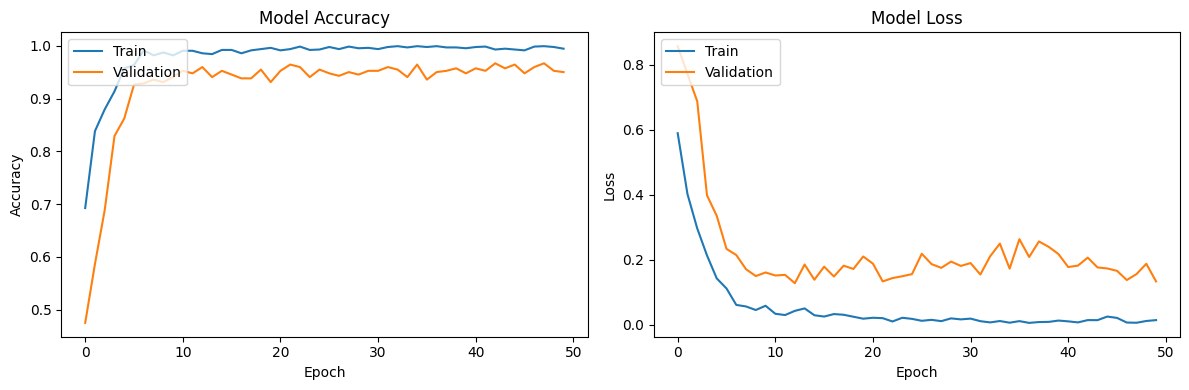

Final training accuracy: 0.9945
Final validation accuracy: 0.9501
Final training loss: 0.0138
Final validation loss: 0.1328


In [75]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Print final training and validation metrics
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")




In [ ]:
# Evaluate the model
model.evaluate(test_images, test_labels, batch_size=batch_size)
# print(f"Test accuracy: {test_accuracy:.4f}")

# Generate predictions
predictions = model.predict(test_images, batch_size=batch_size)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# The rest of your code remains the same
print("Unique values in test_labels:", np.unique(val_labels))
print("Unique values in predicted_classes:", np.unique(predicted_classes))

labels = sorted(np.unique(np.concatenate([val_labels, predicted_classes])))
target_names = ['Non-Gingivitis' if l == 0 else 'Gingivitis' for l in labels]

cm = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix 5th Iteration')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, predicted_classes, labels=labels, target_names=target_names, zero_division=1))

In [ ]:
# Model evaluation using new data testing
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the path to your test data folder
test_data_dir = r'C:\Users\alian\Downloads\skripshoot\test data'

# Function to load images from a directory
def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(0 if class_name == 'non-gingi' else 1)
    return np.array(images), np.array(labels)

# Load test images and labels
test_images, test_labels = load_images_from_directory(test_data_dir)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=batch_size)
print(f"Test accuracy: {test_accuracy:.4f}")

# Generate predictions
predictions = model.predict(test_images, batch_size=batch_size)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# The rest of your code remains the same
print("Unique values in test_labels:", np.unique(test_labels))
print("Unique values in predicted_classes:", np.unique(predicted_classes))

labels = sorted(np.unique(np.concatenate([test_labels, predicted_classes])))
target_names = ['Non-Gingivitis' if l == 0 else 'Gingivitis' for l in labels]

cm = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix 4th Iteration')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, predicted_classes, labels=labels, target_names=target_names, zero_division=1))